In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from florishelpers import MyFlorisInterface
from xarray import Dataset

# Gaussian wake model
From Bastankhah & Porte-Agel, implemented in [FLORIS](https://github.com/NREL/floris) as the `Gauss` wake-velocity model

In [3]:
D = 27.
zhub = 32.1
downstream_distances = [2,3,4,5]  # D
ds = 1.0

In [4]:
conditions = {
    'neutral': dict(
        air_density=1.02,
        wind_speed=8.7,
        turbulence_intensity=0.107,
        wind_shear=0.14,
    ),
    'unstable': dict(
        air_density=1.09,
        wind_speed=6.7,
        turbulence_intensity=0.126,
        wind_shear=0.14,
    ),
    'stable': dict(
        air_density=1.06,
        wind_speed=4.8,
        turbulence_intensity=0.034,
        wind_shear=0.50,
    ),
}

## run floris for all cases

In [5]:
flor = MyFlorisInterface('V27_v3.json', D=D, zhub=zhub, sampling_resolution=ds)

Using default gauss deflection multipler of 1.2


Calculating neutral
 with properties {'air_density': 1.02, 'wind_speed': 8.7, 'turbulence_intensity': 0.107, 'wind_shear': 0.14}
plotting at x=2D, y=0 and z=32.1
plotting at x=3D, y=0 and z=32.1
plotting at x=4D, y=0 and z=32.1
plotting at x=5D, y=0 and z=32.1
Calculating unstable
 with properties {'air_density': 1.09, 'wind_speed': 6.7, 'turbulence_intensity': 0.126, 'wind_shear': 0.14}
plotting at x=2D, y=0 and z=32.1
plotting at x=3D, y=0 and z=32.1
plotting at x=4D, y=0 and z=32.1
plotting at x=5D, y=0 and z=32.1
Calculating stable
 with properties {'air_density': 1.06, 'wind_speed': 4.8, 'turbulence_intensity': 0.034, 'wind_shear': 0.5}
plotting at x=2D, y=0 and z=32.1
plotting at x=3D, y=0 and z=32.1
plotting at x=4D, y=0 and z=32.1
plotting at x=5D, y=0 and z=32.1


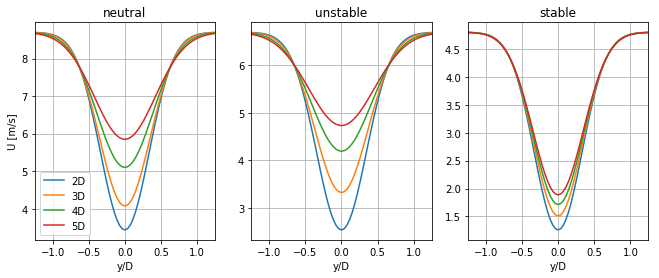

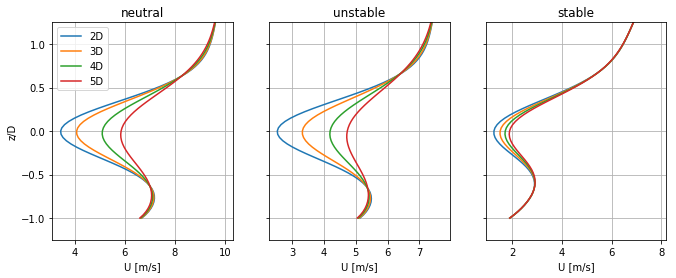

In [6]:
figh,axh = plt.subplots(ncols=len(conditions.keys()), sharex=True, figsize=(11,4))
figv,axv = plt.subplots(ncols=len(conditions.keys()), sharey=True, figsize=(11,4))

# create dictionary of lists of wake planes for all conditions
wake = {}
for icol,(key,properties) in enumerate(conditions.items()):
    print('Calculating',key)
    print(' with properties',properties)
    flor.update_flow(**properties)
    for i,downD in enumerate(downstream_distances):
        y,z,u = flor.get_downstream_plane(downD)
        # save data
        if i==0:
            wake[key] = [u]
        else:
            wake[key].append(u)
        # get profiles and plot
        j0 = np.argmin(np.abs(y[:,0]))
        khub = np.argmin(np.abs(z[0,:] - zhub))
        print('plotting at x={:g}D, y={:g} and z={:g}'.format(downD, y[j0,0],z[0,khub]))
        axh[icol].plot(y[:,khub]/D, u[:,khub], label='{:d}D'.format(downD))
        axv[icol].plot(u[j0,:], (z[j0,:]-zhub)/D, label='{:d}D'.format(downD))
        axh[icol].grid(True)
        axv[icol].grid(True)
    axh[icol].set_title(key)
    axv[icol].set_title(key)
    axh[icol].set_xlabel('y/D')
    axv[icol].set_xlabel('U [m/s]')
axh[0].set_ylabel('U [m/s]')
axh[0].set_xlim((-1.25,1.25))
axh[0].legend()
figh.savefig('Gauss_wake_yprofiles.png', bbox_inches='tight')
axv[0].set_ylabel('z/D')
axv[0].set_ylim((-1.25,1.25))
axv[0].legend()
figv.savefig('Gauss_wake_zprofiles.png', bbox_inches='tight')

## add freestream reference

In [7]:
all_distances = [-2.5] + downstream_distances

In [8]:
allplanes = {}
for key,cond in conditions.items():
    Uref = cond['wind_speed'] * (z / zhub)**cond['wind_shear']
    # prepend inflow plane
    allplanes[key] = [Uref] + wake[key]

## create dataset

In [9]:
# assuming y and z are identical in all cases
#x1 = np.array(downstream_distances) * D
x1 = np.array(all_distances) * D
y1 = y[:,0]
z1 = z[0,:]

In [10]:
for key in conditions.keys():
    udata = np.stack(allplanes[key],axis=0)
    ncdata = Dataset(
        data_vars={
            'u':(['x','y','z'], udata)
        },
        coords={
            'x': x1,
            'y': y1,
            'z': z1,
        }
    )
    fpath = 'Gauss_{:s}.nc'.format(key)
    ncdata.to_netcdf(fpath)
    print('Wrote',fpath)

Wrote Gauss_neutral.nc
Wrote Gauss_unstable.nc
Wrote Gauss_stable.nc


In [11]:
ncdata

<xarray.Dataset>
Dimensions:  (x: 5, y: 109, z: 82)
Coordinates:
  * x        (x) float64 -67.5 54.0 81.0 108.0 135.0
  * y        (y) float64 -54.0 -53.0 -52.0 -51.0 -50.0 ... 51.0 52.0 53.0 54.0
  * z        (z) float64 5.1 6.1 7.1 8.1 9.1 10.1 ... 82.1 83.1 84.1 85.1 86.1
Data variables:
    u        (x, y, z) float64 1.913 2.092 2.257 2.411 ... 7.769 7.815 7.861